In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Load your preprocessed dataset
data = pd.read_csv('/content/preprocessed_dataset.csv')



In [ ]:
# 'cleaned_comment' is the preprocessed comment text and 'labels' is the sarcasm label (0 or 1)
X = data['cleaned_comment']
y = data['labels']



In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)



In [ ]:
# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

# Reshape the data for the CNN model
X_train = np.expand_dims(X_train_tfidf.toarray(), axis=2)  # Convert sparse matrix to dense array and add channel dimension
X_test = np.expand_dims(X_test_tfidf.toarray(), axis=2)    # Convert sparse matrix to dense array and add channel dimension


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Define input shape based on X_train dimensions
input_shape = (X_train.shape[1], 1)

# Number of classes
num_classes = y_train.shape[1]

# Build the CNN model
model = Sequential()

# Convolutional layers: Learn spatial features
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Flatten layer: Prepare for dense layers
model.add(Flatten())

# Dense layers: Extract higher-level features and classify
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output layer with appropriate activation (e.g., sigmoid for binary classification, softmax for multi-class)
model.add(Dense(num_classes, activation='softmax'))  # Adjust for your number of classes



In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',  # Adjust loss for your problem (e.g., 'binary_crossentropy' for binary)
              optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
              metrics=['accuracy'])



In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))



Epoch 1/20
243/243 [==============================] - 14s 27ms/step - loss: 0.7703 - accuracy: 0.6668 - val_loss: 0.7238 - val_accuracy: 0.7132
Epoch 2/20
243/243 [==============================] - 6s 25ms/step - loss: 0.7091 - accuracy: 0.7248 - val_loss: 0.6993 - val_accuracy: 0.7237
Epoch 3/20
243/243 [==============================] - 6s 23ms/step - loss: 0.6694 - accuracy: 0.7499 - val_loss: 0.6807 - val_accuracy: 0.7389
Epoch 4/20
243/243 [==============================] - 6s 24ms/step - loss: 0.6396 - accuracy: 0.7766 - val_loss: 0.6712 - val_accuracy: 0.7415
Epoch 5/20
243/243 [==============================] - 6s 24ms/step - loss: 0.6171 - accuracy: 0.7896 - val_loss: 0.6729 - val_accuracy: 0.7474
Epoch 6/20
243/243 [==============================] - 6s 25ms/step - loss: 0.5967 - accuracy: 0.8007 - val_loss: 0.6867 - val_accuracy: 0.7353
Epoch 7/20
243/243 [==============================] - 6s 23ms/step - loss: 0.5825 - accuracy: 0.8099 - val_loss: 0.6903 - val_accuracy: 0.742

In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict on test data
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Convert one-hot encoded y_test back to categorical labels
y_test_classes = np.argmax(y_test, axis=1)


# Calculate F1 score
f1 = f1_score(y_test_classes, y_test_pred_classes)
print(f"Test F1 Score: {f1}")

# Print classification report
print(classification_report(y_test_classes, y_test_pred_classes))

122/122 [==============================] - 1s 7ms/step - loss: 0.8160 - accuracy: 0.7302
Test Loss: 0.8160125017166138
Test Accuracy: 0.7301750779151917
122/122 [==============================] - 1s 5ms/step
Test F1 Score: 0.6771410967344423
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      2178
           1       0.71      0.64      0.68      1706

    accuracy                           0.73      3884
   macro avg       0.73      0.72      0.72      3884
weighted avg       0.73      0.73      0.73      3884



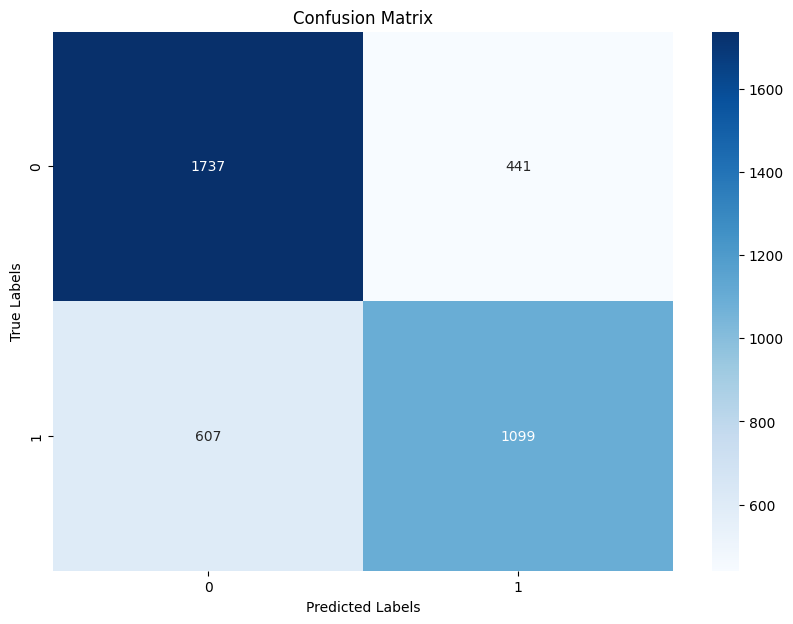

In [ ]:
 # Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_test_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()